In [1]:
import xarray as xr
import dask
import numpy as np
import matplotlib.pyplot as plt
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
from scipy.interpolate import CubicSpline
import copy
import pandas as pd
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/src')
from src import *
from GLODAP_gridding_tools import *

In [2]:
plotsdir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/figures/" + x
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/" + x

## Load in GLODAPv2

In [ ]:
ds = pd.read_csv(datadir('GLODAPv2.2023_Merged_Master_File.csv'),na_values=9999)
ds = ds.replace(-9999, np.nan)

## Select objective grid, variables and year 

In [6]:
regular_lon = np.arange(-180, 180, 2)
regular_lat = np.arange(-90, 90, 2)
gridded_z = np.arange(10, 5000, 75)
varns = ["G2cfc12", "G2cfc11", "G2sf6", "G2temperature", "G2salinity"]
vars_dicts, casts_dict = GLODAP_2_regular_grid(ds, gridded_z, regular_lat, regular_lon, 
                                            varns = varns, year = 2020.)

G2cfc12
G2cfc11
G2sf6
G2temperature
G2salinity


## Compare original observations and the gridded data 

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: shading value 'auto|' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  result = super().pcolormesh(*args, **kwargs)


Text(0.5, 1.0, '2° x 2° Gridded Data')

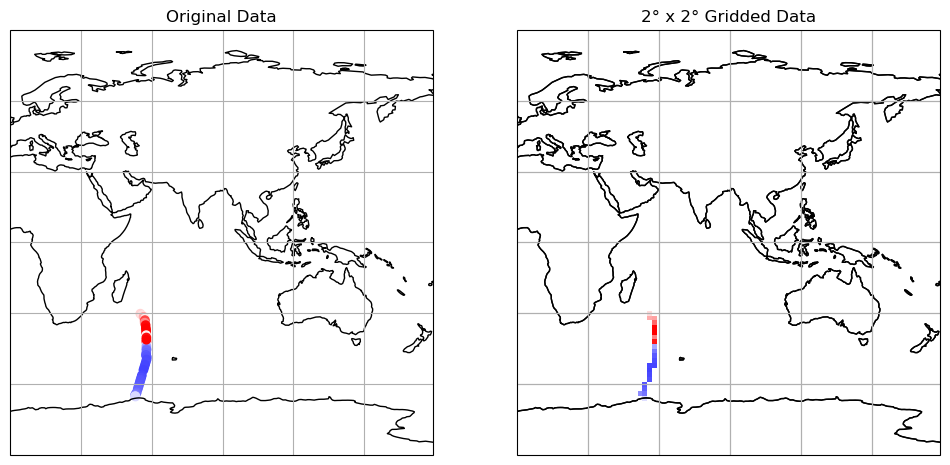

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10), subplot_kw={'projection':ccrs.PlateCarree()})

[a.set_extent([0, 179, -90, 90], ccrs.PlateCarree()) for a in axes]
[a.gridlines() for a in axes]
[a.coastlines() for a in axes]

axes[0].scatter(casts_dict["G2cfc12"].lon[:], 
                casts_dict["G2cfc12"].lat[:], 
                c = casts_dict["G2cfc12"].G2cfc12[17, :][:], vmin = 0, vmax = 1, transform=ccrs.PlateCarree(), cmap = "bwr")

axes[1].pcolormesh(vars_dicts["G2cfc12"].lon,
                   vars_dicts["G2cfc12"].lat, 
                   vars_dicts["G2cfc12"].G2cfc12[:, :, 17].T, 
                   vmin = 0, vmax = 1, 
                   transform=ccrs.PlateCarree(), cmap = "bwr", shading="auto|")

axes[1].set_extent([0, 179, -90, 90], ccrs.PlateCarree())
axes[1].gridlines()
axes[1].coastlines()

axes[0].set_title("Original Data")
axes[1].set_title("2° x 2° Gridded Data")

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: shading value 'auto|' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  result = super().pcolormesh(*args, **kwargs)


Text(0.5, 1.0, '2° x 2° Gridded Data')

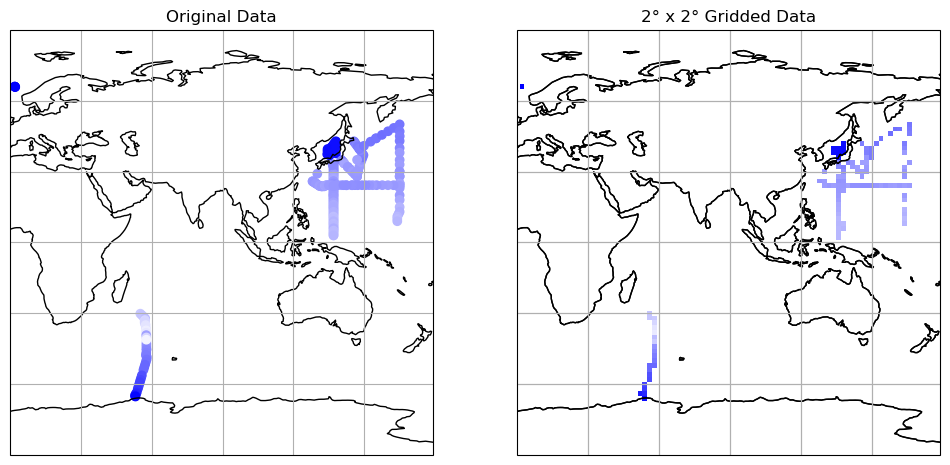

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10), subplot_kw={'projection':ccrs.PlateCarree()})

[a.set_extent([0, 179, -90, 90], ccrs.PlateCarree()) for a in axes]
[a.gridlines() for a in axes]
[a.coastlines() for a in axes]

axes[0].scatter(casts_dict["G2temperature"].lon[:], 
                casts_dict["G2temperature"].lat[:], 
                c = casts_dict["G2temperature"].G2temperature[17, :][:], vmin = 0, vmax = 10, transform=ccrs.PlateCarree(), cmap = "bwr")

axes[1].pcolormesh(vars_dicts["G2temperature"].lon,
                   vars_dicts["G2temperature"].lat, 
                   vars_dicts["G2temperature"].G2temperature[:, :, 17].T, 
                   vmin = 0, vmax = 10, 
                   transform=ccrs.PlateCarree(), cmap = "bwr", shading="auto|")

axes[1].set_extent([0, 179, -90, 90], ccrs.PlateCarree())
axes[1].gridlines()
axes[1].coastlines()

axes[0].set_title("Original Data")
axes[1].set_title("2° x 2° Gridded Data")

## Create a grid for all years 

In [115]:
regular_lon = np.arange(-180, 180, 2)
regular_lat = np.arange(-90, 90, 2)
gridded_z = np.arange(10, 5000, 75)

varns = ["G2cfc12", "G2cfc11", "G2sf6", "G2temperature", "G2salinity"]

tregvars = dict()
tcastvars =  dict()
year_range = range(1990, 2021)
for (tt, y) in enumerate(year_range):
    print(tt / len(year_range))
    
    vars_dicts, casts_dict = grid_yearly_GLODAP(ds, regular_z, regular_lat, regular_lon, 
                                                varns = varns, year = y)
    vars_dicts = xr.merge(vars_dicts.values())
    tregvars[y] = vars_dicts

tmp_list = []
for val in tregvars.values():
    tmp_list += [val.assign_coords({"time":val.time })]

#save gridded data 
GLODAP_gridded = xr.concat(tmp_list, dim = "time")
GLODAP_gridded.to_netcdf("GLODAP_gridded.nc", compute = True)

## Plot composites

Text(0.5, 1.0, 'CFC12 (2010 — 2020)')

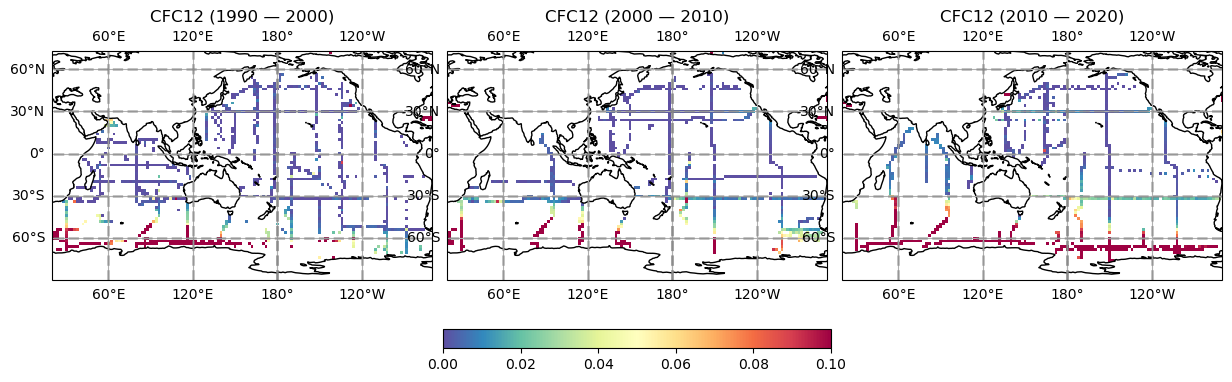

In [122]:
fig, axes = plt.subplots(1, 3, figsize=(12, 10), subplot_kw={'projection':ccrs.PlateCarree(central_longitude = 180)})
[a.set_extent([20, 290, -90, 73], ccrs.PlateCarree()) for a in axes]
[a.gridlines() for a in axes]
[a.coastlines() for a in axes]

cfc_gridded.sel(time = slice(1990, 2000), z = slice(3000, 4000)).T.mean(["time", "z"]).plot.pcolormesh(ax=axes[0], 
                                                                        vmin = 0, vmax = 0.1, cmap = "Spectral_r", 
                                                                        add_colorbar = False, transform=ccrs.PlateCarree())

cm = cfc_gridded.sel(time = slice(2000, 2010), z = slice(3000, 4000)).T.mean(["time", "z"]).plot.pcolormesh(ax=axes[1], 
                                                                        vmin = 0, vmax = 0.1, cmap = "Spectral_r", 
                                                                        add_colorbar = False, transform=ccrs.PlateCarree())
cfc_gridded.sel(time = slice(2010, 2020), z = slice(3000, 4000)).T.mean(["time", "z"]).plot.pcolormesh(ax=axes[2], 
                                                                                                             vmin = 0, vmax = 0.1, cmap = "Spectral_r", 
                                                                                                             add_colorbar = False, transform = ccrs.PlateCarree())
fig.tight_layout()
fig.colorbar(cm, ax = axes[:], orientation = "horizontal", fraction  = 0.02, pad = 0.05)

[a.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--') for a in axes]

axes[0].set_title("CFC12 (1990 — 2000)")
axes[1].set_title("CFC12 (2000 — 2010)")
axes[2].set_title("CFC12 (2010 — 2020)")

Text(0.5, 1.0, 'CFC12 (2010 — 2020)')

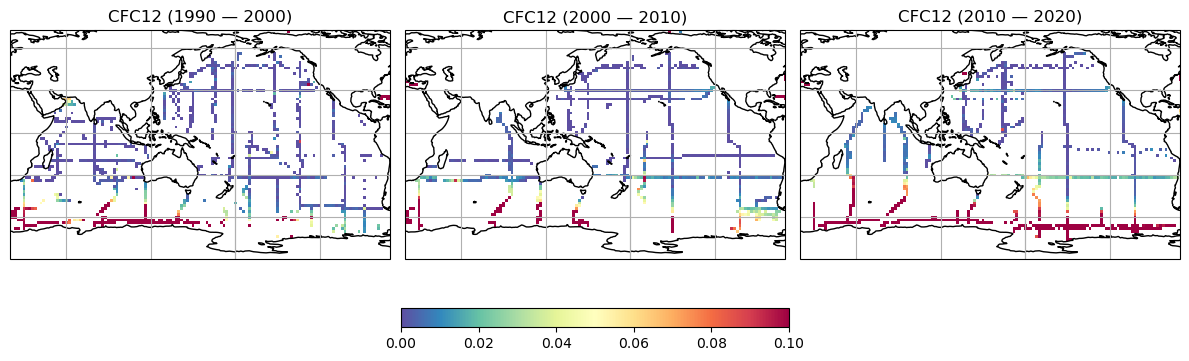

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(12, 10), subplot_kw={'projection':ccrs.PlateCarree(central_longitude = 180)})
[a.set_extent([20, 290, -90, 73], ccrs.PlateCarree()) for a in axes]
[a.gridlines() for a in axes]
[a.coastlines() for a in axes]

cfc_gridded.sel(time = slice(1990, 2000), depth = slice(3000, 4000)).mean(["time", "depth"]).plot.pcolormesh(ax=axes[0], 
                                                                        vmin = 0, vmax = 0.1, cmap = "Spectral_r", 
                                                                        add_colorbar = False, transform=ccrs.PlateCarree())

cm = cfc_gridded.sel(time = slice(2000, 2010), depth = slice(3000, 4000)).mean(["time", "depth"]).plot.pcolormesh(ax=axes[1], 
                                                                        vmin = 0, vmax = 0.1, cmap = "Spectral_r", 
                                                                        add_colorbar = False, transform=ccrs.PlateCarree())
cfc_gridded.sel(time = slice(2010, 2020), depth = slice(3000, 4000)).mean(["time", "depth"]).plot.pcolormesh(ax=axes[2], 
                                                                                                             vmin = 0, vmax = 0.1, cmap = "Spectral_r", 
                                                                                                             add_colorbar = False, transform = ccrs.PlateCarree())
fig.tight_layout()
fig.colorbar(cm, ax = axes[:], orientation = "horizontal", fraction  = 0.02, pad = 0.05)

[a.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--') for a in axes]

axes[0].set_title("CFC12 (1990 — 2000)")
axes[1].set_title("CFC12 (2000 — 2010)")
axes[2].set_title("CFC12 (2010 — 2020)")